# Apply PSO on Matching Network Optimization
From separate code on PSO and Matching Network, it's time to merge these 2 to make an optimization for MN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

----------------------------------------------------------
## I. Define Matching Network

Still, suppose I have a MN of 5 component like this:

*-------------L2-------------------C3---------------C1---------------*

     |          |             |             |
           
    Z_out      L1             C2             Z_load
           
     |          |             |             |
      
*---------------------------------------------------------------------*

and Z_load is not matched at 50Ohm, so with help from MN, I expect to get Z_out matched

Let's try to simplify the parallel or series type of a circuit

In [2]:
def parallel(Z1, Z2):
    return 1/(1/Z1 + 1/Z2)

def series(Z1, Z2): 
    return Z1 + Z2

Then, I assign type (R/L/C), connection orientation (ser/par), lowest and highest values of 5 components, respectively:

In [3]:
num_component = 5

component_type = ('C', 'C', 'C', 'L', 'L')
component_topology = ('ser', 'par','ser', 'par','ser')
range_C = (1e-12, 100e-12)
range_distance_C = range_C[1] - range_C[0]
range_L = (1e-9, 100e-9)
range_distance_L = range_L[1] - range_L[0]

And the function to calculate output impedance from Z load and MN

*note: for component type: 0 - C, 1 - L, 2 - R; for component placement: 0 - series, 1 - parallel*

In [4]:
def out_impedance(num_component, components, freq, Z_load):
    Z = np.zeros((num_component+1,),dtype = complex)
    Z_out = np.zeros((num_component+1,),dtype = complex)
    # calculate impedance of each component
    Z[0] = Z_load
    #print (Z[0],end = '   ')
    for i in range(num_component):
        if components[i][0] == 0: # C
            Z[i+1] = 1/(1j*2*np.pi*freq*components[i][2])
        elif components[i][0] == 1: # L
            Z[i+1] = 1j*2*np.pi*freq*components[i][2]
        else: # R
            Z[i+1] = components[i][2]
    # calculate result
    Z_out[0] = Z_load
    for i in range(num_component):
        if components[i][1] == 0: # series
            Z_out[i+1] = series(Z_out[i], Z[i+1])
        else:                     # parallel
            Z_out[i+1] = parallel(Z_out[i], Z[i+1])
        #print ('\n Zout', i+1,' :', Z_out[i+1])
    return Z_out[num_component]

---------------------------------------------
## II. Apply PSO
General parameters of PSO are defined here, meaning of them is *PSOsinc* notebook


In [5]:
w = 0.3
c1 = 2
c2 = 2
max_iter = 100
freq = 1e+9
Z_load = 20
Z0 = 50

### First step
Define the Solution Space

10 bees, or better-10 particles, will be assigned to the task to look for the best position in their so-called Solution Space. This space is 5D, as each agent needs 5 variables to define its location, seem unrealistic hah? :v

In [6]:
agent_quantity = 20
space_dimention = 5
agent_bound = np.zeros([num_component,2])
for i in range(space_dimention):
    if component_type[i] == 'C':
        agent_bound[i] = range_C
    else:
        agent_bound[i] = range_L
agent_bound

array([[1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-09, 1.e-07],
       [1.e-09, 1.e-07]])

### Second step
Define a fitness function. In this case, it's the S11 at given frequency

In [7]:
def fitness(agent):
    components = np.zeros([num_component,3])
    for i in range(num_component):
        # Component type
        if component_type[i] == 'C':
            components[i][0] = 0 # C
        elif component_type[i] == 'L':
            components[i][0] = 1 # L
        else:
            components[i][0] = 1 # R
        # Component placement
        if component_topology[i] == 'ser':
            components[i][1] = 0
        else:
            components[i][1] = 1
        # Component value
        components[i][2] = agent[i]
        
    #print(components)
    Z_out = out_impedance(num_component, components, freq, Z_load)
    fitness = np.abs((Z_out - Z0)/(Z_out + Z0))
    return 1 - fitness
# Check fitness function
fitness([10e-12, 20e-12, 30e-12, 40e-9, 50e-9])

0.0015327902737268806

### Third step 
Initialize Random Swam Location and Velocities

In [8]:
agent_location = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_location

array([[9.33761028e-11, 9.30628049e-11, 9.53496320e-11, 1.16626670e-08,
        2.14570656e-08],
       [9.30913425e-11, 6.15457494e-11, 1.69731336e-11, 6.75657522e-08,
        7.02798670e-08],
       [2.38345452e-11, 5.74721844e-11, 7.70198390e-12, 6.58136911e-08,
        2.01834331e-08],
       [8.71495981e-11, 6.59069293e-11, 3.74343805e-11, 1.52350602e-08,
        4.45111943e-08],
       [4.85487518e-11, 4.06644835e-11, 1.64180158e-11, 2.37334524e-08,
        1.14060926e-08],
       [5.39246468e-11, 8.44712520e-11, 8.58564749e-11, 5.55696762e-08,
        6.84239817e-08],
       [3.21410426e-11, 2.37394247e-11, 9.88652610e-11, 8.65121768e-08,
        2.83811558e-08],
       [8.90756268e-11, 6.32183752e-11, 1.86746138e-12, 9.19370604e-08,
        7.82354736e-08],
       [2.66475261e-11, 6.00272279e-11, 7.74723053e-11, 1.29612212e-08,
        8.33625880e-09],
       [3.02828479e-11, 4.82861733e-11, 6.99553513e-11, 3.98890758e-08,
        8.01971527e-08],
       [2.28525031e-11, 8.2061

*pbest at first is also the first swam*

In [9]:
agent_pbest = agent_location

In [10]:
agent_velocity = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_velocity

array([[7.99721522e-11, 8.69516056e-11, 2.23561476e-11, 4.54898013e-08,
        5.80619625e-08],
       [3.90262748e-11, 2.54955140e-11, 1.13224841e-11, 6.31485722e-08,
        2.82609509e-08],
       [5.45221494e-11, 6.84244140e-11, 3.89149012e-11, 2.70951669e-09,
        8.58023109e-08],
       [1.01391932e-11, 1.66659658e-11, 4.89205796e-11, 4.21899092e-08,
        9.21778499e-08],
       [3.23207101e-12, 4.84033109e-11, 4.04050937e-11, 2.71011697e-08,
        7.44172603e-08],
       [4.11916103e-11, 8.86404290e-11, 6.99503535e-11, 6.64734389e-09,
        4.68225068e-08],
       [1.92757090e-11, 8.84306363e-11, 4.87584463e-11, 6.33205619e-08,
        6.29920250e-08],
       [7.19198750e-11, 7.99448223e-11, 2.36241356e-11, 3.12329983e-08,
        4.61812051e-08],
       [2.00389119e-11, 9.68816558e-11, 9.32581551e-11, 6.41284088e-08,
        6.75756410e-08],
       [4.64869220e-11, 6.09687534e-11, 9.32230942e-11, 8.42113247e-08,
        6.11768708e-08],
       [6.49229127e-11, 3.2399

### Fourth step
Systematically Fly the Particles Through the Solution Space

a) Evaluate the Particles's Fitness, Compare to gbest, pbest

In [11]:
agent_fitness = np.zeros([agent_quantity,1])
pbest = np.zeros([agent_quantity,1])

for i in range(0,agent_quantity):
    agent_fitness[i] = fitness(agent_location[i])
    if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
pbest

array([[7.90234997e-04],
       [1.81054276e-04],
       [2.71820275e-03],
       [4.19106410e-04],
       [1.41344750e-02],
       [9.30283074e-05],
       [5.42175913e-03],
       [2.74741694e-04],
       [6.96729028e-03],
       [1.91126450e-04],
       [3.63928771e-03],
       [1.94273874e-04],
       [8.35754799e-03],
       [4.08868863e-03],
       [3.40631220e-04],
       [4.64701900e-03],
       [2.39575421e-03],
       [2.44907070e-04],
       [4.36117792e-04],
       [2.95669722e-04]])

In [12]:
gbest = np.zeros(1)
gbest[0] = pbest.max()
gbest_position = pbest.argmax()
print('\n Global best', gbest[0])
print('\n Global best position', gbest_position)
print('\n Agent at best position', agent_pbest[gbest_position])


 Global best 0.014134474951247977

 Global best position 4

 Agent at best position [4.85487518e-11 4.06644835e-11 1.64180158e-11 2.37334524e-08
 1.14060926e-08]


b) Update the Particle's velocity 

In [13]:
for i in range(agent_quantity):
    agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
agent_velocity

array([[-1.21780542e-11, -1.61929825e-11, -5.69804538e-11,
         2.33864560e-08,  9.30879265e-09],
       [-1.19333166e-11, -3.43418032e-12,  3.10211371e-12,
        -4.31963700e-09, -2.27692600e-08],
       [ 5.74338345e-11, -7.40855602e-12,  2.61612836e-11,
        -6.91282107e-08,  1.11519798e-08],
       [-1.30606753e-11, -5.53015552e-12,  5.90914820e-12,
         1.62020969e-08,  1.38434844e-08],
       [ 9.69621304e-13,  1.45209933e-11,  1.21215281e-11,
         8.13035092e-09,  2.23251781e-08],
       [ 8.70154172e-12, -3.19918565e-12, -2.62373447e-11,
        -1.96563998e-08, -2.47289422e-08],
       [ 3.14064367e-11,  5.29608536e-11, -1.14129346e-10,
        -7.90446171e-08, -7.61214634e-09],
       [ 1.18195873e-11,  1.85538588e-11,  1.05901179e-11,
        -7.04932827e-09, -2.23403701e-09],
       [ 1.73251947e-11,  1.90622795e-11, -3.56138153e-12,
         2.48031365e-08,  2.18584770e-08],
       [ 3.00145744e-11,  1.15858330e-11, -1.91298132e-11,
         1.10513113e-08

c) Move the particle

In [14]:
agent_location = agent_location + agent_velocity
for i in range(agent_quantity):
    for j in range(space_dimention):
        if agent_location[i][j] > agent_bound[j][1]:
            agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
        if agent_location[i][j] < agent_bound[j][0]:
            agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
        
agent_location

array([[8.11980486e-11, 7.68698224e-11, 3.83691782e-11, 3.50491230e-08,
        3.07658583e-08],
       [8.11580259e-11, 5.81115691e-11, 2.00752473e-11, 6.32461152e-08,
        4.75106070e-08],
       [8.12683798e-11, 5.00636283e-11, 3.38632675e-11, 5.31451962e-09,
        3.13354128e-08],
       [7.40889228e-11, 6.03767738e-11, 4.33435287e-11, 3.14371572e-08,
        5.83546787e-08],
       [4.95183731e-11, 5.51854768e-11, 2.85395439e-11, 3.18638033e-08,
        3.37312707e-08],
       [6.26261885e-11, 8.12720663e-11, 5.96191302e-11, 3.59132764e-08,
        4.36950395e-08],
       [6.35474793e-11, 7.67002783e-11, 1.72640854e-11, 7.46755967e-09,
        2.07690094e-08],
       [9.91047859e-11, 8.17722340e-11, 1.24575793e-11, 8.48877321e-08,
        7.60014366e-08],
       [4.39727208e-11, 7.90895074e-11, 7.39109238e-11, 3.77643577e-08,
        3.01947358e-08],
       [6.02974223e-11, 5.98720063e-11, 5.08255380e-11, 5.09403872e-08,
        3.80347859e-08],
       [6.53388437e-11, 5.4712

### Fifth step
Repeat everything in Step 4 untill iteration being out of range 

In [15]:
converge_flag = 0
for k in range(max_iter):
    if gbest[k] > 0.99:
        converge_flag = 1
        print('Converged!!! Hura!!')
        break
    # Step 4a
    for i in range(agent_quantity):
        agent_fitness[i] = fitness(agent_location[i])
        if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
    gbest = np.append(gbest, pbest.max())
    gbest_position = pbest.argmax()
    # Step 4b
    for i in range(agent_quantity):
        agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
    # Step 4c
    agent_location = agent_location + agent_velocity
    for i in range(agent_quantity):
        for j in range(space_dimention):
            if agent_location[i][j] > agent_bound[j][1]:
                agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
            if agent_location[i][j] < agent_bound[j][0]:
                agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
    #print('Iteration: ', k)
    #print('Gbest in this iteration: ', gbest)

if converge_flag == 0:
    k +=1 
print('\n Agent at best position', agent_pbest[gbest_position])            
print('Gbest value is ', gbest[k])

Converged!!! Hura!!

 Agent at best position [2.05182672e-11 5.44973718e-12 1.66649375e-11 4.74428257e-09
 2.40034367e-09]
Gbest value is  0.9900300609594072


-----------------------------------------------------------
# III. Result
Final result is shown here, good or not, it've already taken a lot of time. Let's try to draw a graph to see the convergence progress

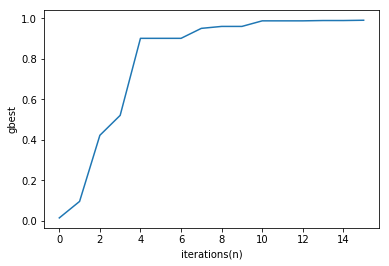

In [16]:
iterate = np.arange(k+1)
plt.plot(iterate,gbest)
plt.xlabel('iterations(n)')
plt.ylabel('gbest')
plt.show()

In [17]:
agent_gbest = agent_pbest[gbest_position]
components = np.zeros([num_component,3])
for i in range(num_component):
    # Component type
    if component_type[i] == 'C':
        components[i][0] = 0 # C
    elif component_type[i] == 'L':
        components[i][0] = 1 # L
    else:
        components[i][0] = 1 # R
    # Component placement
    if component_topology[i] == 'ser':
        components[i][1] = 0
    else:
        components[i][1] = 1
    # Component value
    components[i][2] = agent_gbest[i]
        
#print(components)
Z_out = out_impedance(num_component, components, freq, Z_load)
print('Z output is ', Z_out)

Z output is  (49.73483033085407-0.9583885557324834j)
